<a href="https://colab.research.google.com/github/Jaime44/WorkSpace/blob/main/models/rnn_rs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys

In [2]:
# Comprueba si el código se está ejecutando en Google Colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

path_absolute = ''
if IN_COLAB:
    print("El código se está ejecutando en Google Colab.")
    from google.colab import drive

    drive.mount('/content/drive')
    path_absolute = '/content/drive/Othercomputers/Mi_portátil/TFM/WorkSpace/'

    # Cambia al directorio de tu carpeta en Google Drive
    os.chdir(path_absolute)

    # Lista los archivos y carpetas en el directorio actual
    contenido_carpeta = os.listdir(path_absolute)
    print("Contenido de la carpeta en Google Drive:")
    print(contenido_carpeta)
else:
    print("El código se está ejecutando en un entorno local.")
    path_absolute = 'C:/Users/jaime/OneDrive - Universidad de Málaga/Escritorio/UNIR/TFM/WorkSpace/'

path_file = 'df_movies_rating_2.csv'

sys.path.append(path_absolute)


El código se está ejecutando en un entorno local.


In [14]:
import numpy as np
import pandas as pd

import Utils.utils as util


from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate

# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset


In [15]:
dataFrame = pd.read_csv(path_absolute+path_file, sep=',')
data = dataFrame.copy()

In [16]:
if IN_COLAB:
    tamano_muestra = data.shape[0]
else:
    # Especifica el tamaño de la muestra que deseas obtener
    tamano_muestra = 500

In [17]:
# Obtiene una muestra aleatoria uniforme del DataFrame
data = data.sample(n=tamano_muestra, random_state=42)  # random_state para reproducibilidad
tamano_muestra = data.shape[0]  # Cambia esto al tamaño de muestra que desees
tamano_muestra

500

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 550126 to 190092
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   userId              500 non-null    int64  
 1   movieId             500 non-null    int64  
 2   timestamp_scr       500 non-null    int64  
 3   tag                 500 non-null    object 
 4   tag_encoded         500 non-null    int64  
 5   timestamp_tags      500 non-null    int64  
 6   title               500 non-null    object 
 7   (no genres listed)  500 non-null    int64  
 8   Action              500 non-null    int64  
 9   Adventure           500 non-null    int64  
 10  Animation           500 non-null    int64  
 11  Children            500 non-null    int64  
 12  Comedy              500 non-null    int64  
 13  Crime               500 non-null    int64  
 14  Documentary         500 non-null    int64  
 15  Drama               500 non-null    int64  
 16  

Quito las calumnas categoricas de título y tag ambas estan represnetadas en las columnas númericas de tag_encode e id movie.

In [19]:
# util.contar_ocurrencias(data, '(no genres listed)')
# util.mostrar_filas_por_valor(data, '(no genres listed)', 1)

Total de clases(Puntuaciones) a predecir

In [20]:
data = util.eliminar_columnas(data, ['tag', 'title', '(no genres listed)'])
util.contar_ocurrencias(data, 'rating')

Valor: 5.0, Frecuencia: 112
Valor: 4.0, Frecuencia: 105
Valor: 4.5, Frecuencia: 90
Valor: 3.5, Frecuencia: 86
Valor: 3.0, Frecuencia: 51
Valor: 2.5, Frecuencia: 20
Valor: 2.0, Frecuencia: 18
Valor: 1.0, Frecuencia: 8
Valor: 1.5, Frecuencia: 7
Valor: 0.5, Frecuencia: 3
Total de valores distintos: 10


In [22]:
data = util.eliminar_columnas(data, ['timestamp_tags', 'timestamp_scr'])

In [23]:
data.head()

,userId,movieId,tag_encoded,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,rating
550126,64333,42197,31405,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1.5
722840,15078,3993,2699,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,5.0
606031,141263,5459,9448,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1.0
49993,133400,134130,4293,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,5.0
122599,18057,4226,1582,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,5.0


# MODELO CON KERAS

In [24]:
# Dividir datos en entrenamiento y prueba
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# train_data_scaled = train_data[['userId', 'movieId', 'timestamp_scr', 'tag_encoded']]
# test_data_scaled = test_data[['userId', 'movieId', 'timestamp_scr', 'tag_encoded']]

train_data_scaled = train_data.drop("rating", axis=1)
test_data_scaled = test_data.drop("rating", axis=1)
num_features = len(train_data.columns) - 1

# Normalizar datos
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data_scaled)
test_data_scaled = scaler.transform(test_data_scaled)

# Construir el modelo de recomendación sin escalado
model = Sequential()

# Capas de entrada para datos numéricos
model.add(Dense(128, activation='relu', input_shape=(num_features,)))
model.add(Dense(10, activation='relu'))

# Capa de salida para predicción de puntuación
model.add(Dense(1, activation='linear'))

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Entrenar el modelo
history = model.fit(train_data_scaled, train_data['rating'], epochs=100, batch_size=64, validation_split=0.2, verbose=1)

# Evaluar el modelo en el conjunto de prueba
loss, mae = model.evaluate(test_data_scaled, test_data['rating'])
print(f'Mean Absolute Error on Test Data: {mae}')

# Realizar predicciones
predictions = model.predict(test_data_scaled)


Epoch 1/100
5/5 [==============================] - 1s 81ms/step - loss: 9.9487 - mean_absolute_error: 2.9720 - val_loss: 8.6792 - val_mean_absolute_error: 2.7853
Epoch 2/100
5/5 [==============================] - 0s 13ms/step - loss: 7.2885 - mean_absolute_error: 2.4935 - val_loss: 6.1949 - val_mean_absolute_error: 2.3113
Epoch 3/100
5/5 [==============================] - 0s 12ms/step - loss: 5.0800 - mean_absolute_error: 2.0399 - val_loss: 4.1993 - val_mean_absolute_error: 1.8573
Epoch 4/100
5/5 [==============================] - 0s 12ms/step - loss: 3.3828 - mean_absolute_error: 1.5945 - val_loss: 2.7926 - val_mean_absolute_error: 1.4541
Epoch 5/100
5/5 [==============================] - 0s 13ms/step - loss: 2.2741 - mean_absolute_error: 1.2624 - val_loss: 1.9851 - val_mean_absolute_error: 1.1670
Epoch 6/100
5/5 [==============================] - 0s 13ms/step - loss: 1.7323 - mean_absolute_error: 1.0500 - val_loss: 1.6233 - val_mean_absolute_error: 1.0231
Epoch 7/100
5/5 [===========

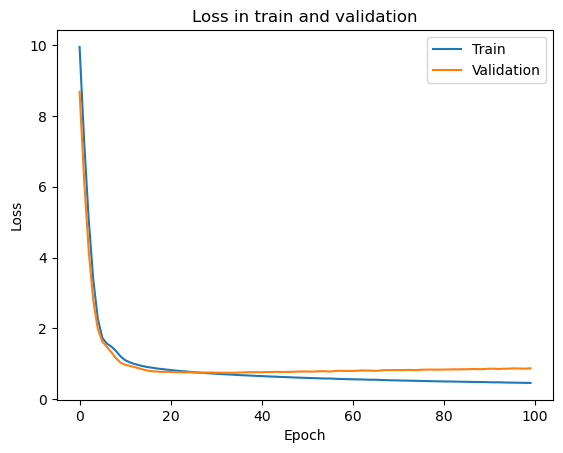

In [25]:
util.plot_loss(history)

# MODELO CON KERAS CON PROCENTAJES

Cambios clave en este código:

- Número de Clases: La capa de salida ahora tiene un número de nodos igual al número de clases únicas en las valoraciones. Esto se determina mediante num_classes.

- Activación Softmax: La capa de salida utiliza la función de activación softmax, que asigna una probabilidad a cada clase y garantiza que la suma de las probabilidades sea igual a 1.

- Loss Function: El modelo utiliza la pérdida categorical_crossentropy porque estamos tratando con múltiples clases.

- One-Hot Encoding: Convertimos las etiquetas de las valoraciones a formato one-hot encoding para adaptarse al formato de salida de la red neuronal.

Después de entrenar el modelo, las predicciones (predictions_proba) serán matrices de probabilidad para cada clase. Puedes interpretar la probabilidad más alta como la predicción de la valoración que el modelo considera más probable para cada ejemplo.

Epoch 1/10
5/5 [==============================] - 1s 79ms/step - loss: 13160.1436 - accuracy: 0.0469 - val_loss: 10505.0703 - val_accuracy: 0.1000
Epoch 2/10
5/5 [==============================] - 0s 13ms/step - loss: 8912.7041 - accuracy: 0.1469 - val_loss: 8211.2803 - val_accuracy: 0.1250
Epoch 3/10
5/5 [==============================] - 0s 13ms/step - loss: 7136.1494 - accuracy: 0.2031 - val_loss: 6029.0742 - val_accuracy: 0.1375
Epoch 4/10
5/5 [==============================] - 0s 12ms/step - loss: 5218.1519 - accuracy: 0.1406 - val_loss: 4032.7141 - val_accuracy: 0.2125
Epoch 5/10
5/5 [==============================] - 0s 12ms/step - loss: 3431.9102 - accuracy: 0.2000 - val_loss: 2352.9587 - val_accuracy: 0.1625
Epoch 6/10
5/5 [==============================] - 0s 13ms/step - loss: 2570.3787 - accuracy: 0.1813 - val_loss: 2201.0327 - val_accuracy: 0.2250
Epoch 7/10
5/5 [==============================] - 0s 13ms/step - loss: 2350.6414 - accuracy: 0.2156 - val_loss: 1996.4954 - val_

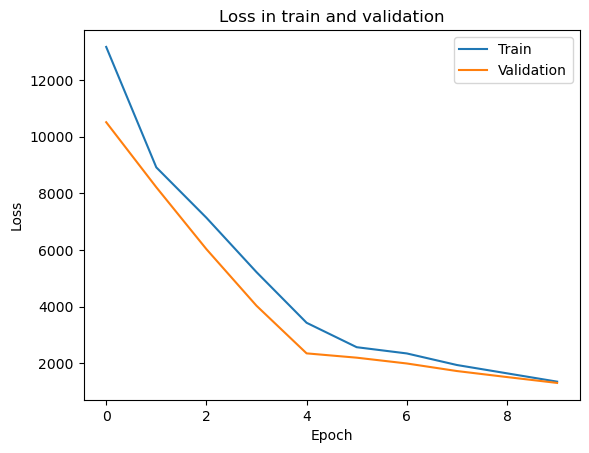

In [30]:
# Convertir las etiquetas a formato one-hot encoding
y_train_onehot = pd.get_dummies(train_data['rating'])
y_test_onehot = pd.get_dummies(test_data['rating'])

# Asegurarse de que las columnas en y_train_onehot y y_test_onehot coincidan
# Esto es necesario porque puede haber algunas clases ausentes en el conjunto de prueba
y_test_onehot = y_test_onehot.reindex(columns=y_train_onehot.columns, fill_value=0)

# Construir el modelo de recomendación con predicción de probabilidad
model = Sequential()

# Capas de entrada para datos numéricos
model.add(Dense(64, activation='relu', input_shape=(len(train_data.columns) - 1,)))
model.add(Dense(32, activation='relu'))

# Capa de salida para predicción de probabilidad con activación softmax
num_classes = len(y_train_onehot.columns)
model.add(Dense(num_classes, activation='softmax'))

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history_perc = model.fit(train_data.drop('rating', axis=1), y_train_onehot, epochs=10, batch_size=64, validation_split=0.2)

# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(test_data.drop('rating', axis=1), y_test_onehot)
print(f'Accuracy on Test Data: {accuracy}')

# Realizar predicciones de probabilidad
predictions_proba = model.predict(test_data.drop('rating', axis=1))

util.plot_loss(history_perc)

    KERAS SIMPLIFICADO

In [ ]:
# Dividir datos en entrenamiento y prueba
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Normalizar datos
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data[['userId', 'movieId', 'timestamp_scr', 'tag_encoded']])
test_data_scaled = scaler.transform(test_data[['userId', 'movieId', 'timestamp_scr', 'tag_encoded']])

# Construir el modelo de recomendación
model = Sequential()

# Capas de entrada para datos numéricos
model.add(Dense(64, activation='relu', input_shape=(train_data_scaled.shape[1],)))
model.add(Dense(32, activation='relu'))

# Capa de salida para predicción de puntuación
model.add(Dense(1, activation='linear'))

#--------------------------------------------------------------------------------------------------------------------------------------------------#

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Entrenar el modelo
model.fit(train_data_scaled, train_data['rating'], epochs=10, batch_size=64, validation_split=0.2)

# Evaluar el modelo en el conjunto de prueba
loss, mae = model.evaluate(test_data_scaled, test_data['rating'])
print(f'Mean Absolute Error on Test Data: {mae}')

# Realizar predicciones
predictions = model.predict(test_data_scaled)


# MODELO CON TORCH

In [ ]:
# # Preprocesamiento de datos
# num_movies = data['movieId'].nunique()

# # Define el tamaño máximo del índice + 1 (porque los índices comienzan desde 0)
# input_dim = max(max(data['userId']), max(data['movieId'])) + 1
# num_movies = input_dim

# # Crear embeddings para usuarios y películas
# user_embedding = nn.Embedding(input_dim, 50)
# movie_embedding = nn.Embedding(input_dim, 50)

# # Crear conjuntos de entrenamiento y prueba
# train, test = train_test_split(data, test_size=0.2, random_state=42)

# # Preparar datos para DataLoader
# train_users = torch.LongTensor(train['userId'].values)
# train_movies = torch.LongTensor(train['movieId'].values)
# train_ratings = torch.FloatTensor(train['rating'].values)

# test_users = torch.LongTensor(test['userId'].values)
# test_movies = torch.LongTensor(test['movieId'].values)
# test_ratings = torch.FloatTensor(test['rating'].values)

# train_dataset = TensorDataset(train_users, train_movies, train_ratings)
# test_dataset = TensorDataset(test_users, test_movies, test_ratings)

# # Crear DataLoader
# batch_size = 512
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size)

# # Definir el modelo de recomendación
# class Recommender(nn.Module):
#     def __init__(self, num_usr, num_movs, embedding_size=50, hidden_size=128):
#         super(Recommender, self).__init__()
#         self.user_embedding = nn.Embedding(num_usr, embedding_size)
#         self.movie_embedding = nn.Embedding(num_movs, embedding_size)
#         self.fc1 = nn.Linear(embedding_size * 2, hidden_size)
#         self.fc2 = nn.Linear(hidden_size, 1)

#     def forward(self, user, movie):
#         user_embed = self.user_embedding(user)
#         movie_embed = self.movie_embedding(movie)
#         x = torch.cat([user_embed, movie_embed], dim=1)
#         x = torch.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

# # Instanciar el modelo, la función de pérdida y el optimizador
# model = Recommender(input_dim, num_movies)
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Entrenar el modelo
# num_epochs = 100

# print_interval = int(num_epochs / 10)

# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0.0
#     for user, movie, rating in train_loader:
#         optimizer.zero_grad()
#         output = model(user, movie).view(-1)
#         loss = criterion(output, rating)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item() * user.size(0)
#     train_loss /= len(train_loader.dataset)
#     # Imprimir progreso cada 10% de las épocas
#     if (epoch + 1) % print_interval == 0 or epoch == num_epochs - 1:
#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}')
#     # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}')

# # Evaluar el modelo en el conjunto de prueba
# model.eval()
# test_loss = 0.0
# with torch.no_grad():
#     for user, movie, rating in test_loader:
#         output = model(user, movie).view(-1)
#         print(f'REAL RATINFG: {rating} ------------ PREDICT RATING {output}')
#         loss = criterion(output, rating)
#         test_loss += loss.item() * user.size(0)
# test_loss /= len(test_loader.dataset)
# print(f'Test Loss: {test_loss:.4f}')


In [ ]:
# # Cargar datos (por ejemplo, desde un archivo CSV)
# # Suponiendo que tienes un DataFrame llamado 'data' con columnas 'userId', 'movieId' y 'rating'
# # ...

# # Preprocesamiento de datos
# # Define el tamaño máximo del índice + 1 (porque los índices comienzan desde 0)
# input_dim = max(max(data['userId']), max(data['movieId'])) + 1

# # Define el tamaño de la capa de embeddings (puedes ajustar este valor según sea necesario)
# embedding_size = 50

# # Crear conjuntos de entrenamiento y prueba
# train, test = train_test_split(data, test_size=0.2, random_state=42)

# # Definir la arquitectura del modelo de recomendación
# user_input = Input(shape=(1,))
# movie_input = Input(shape=(1,))

# user_embedding = Embedding(input_dim=input_dim, output_dim=embedding_size)(user_input)
# movie_embedding = Embedding(input_dim=input_dim, output_dim=embedding_size)(movie_input)

# user_flat = Flatten()(user_embedding)
# movie_flat = Flatten()(movie_embedding)

# concatenated = Concatenate()([user_flat, movie_flat])

# dense_1 = Dense(128, activation='relu')(concatenated)
# output = Dense(1)(dense_1)

# # Crear el modelo
# model = Model(inputs=[user_input, movie_input], outputs=output)

# # Compilar el modelo
# model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.01))

# # Entrenar el modelo
# model.fit([train['userId'], train['movieId']], train['rating'], batch_size=512, epochs=100, validation_split=0.2, verbose=0)

# # Evaluar el modelo en el conjunto de prueba
# loss = model.evaluate([test['userId'], test['movieId']], test['rating'])
# print(f'Loss en el conjunto de prueba: {loss}')
